# initialisation

In [1]:
import backproject
import numpy as np
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import glob
import cv2
import torch
from sklearn.cluster import KMeans


In [2]:
path_to_traj = "/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/traj.txt"
T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)
T_wc[:, 1:3] *= -1
color_paths = sorted(glob.glob("/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame*.jpg"))
print(color_paths)
depth_paths = sorted(glob.glob(f"/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/depth*.png"))
print(depth_paths)

['/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000000.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000001.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000002.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000003.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000004.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000005.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000006.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000007.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000008.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000009.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000010.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000011.jpg', '/h

In [3]:
sam_checkpoint = '/home/koerner/Project/nice-slam/sam/sam_vit_h_4b8939.pth'
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")


mask_generator = SamAutomaticMaskGenerator(
    sam, points_per_side=16, pred_iou_thresh=0.9, stability_score_thresh=0.9, crop_n_layers=1, crop_n_points_downscale_factor=2, min_mask_region_area=1000)



In [4]:
'''
for i in range(20):
    color_path = color_paths[i*50]
    color_data = cv2.imread(color_path)
    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(image)
    images.append(image)
    masksarr.append(masks)
del sam
'''


'\nfor i in range(20):\n    color_path = color_paths[i*50]\n    color_data = cv2.imread(color_path)\n    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)\n    masks = mask_generator.generate(image)\n    images.append(image)\n    masksarr.append(masks)\ndel sam\n'

In [5]:
import vis
import matplotlib.pyplot as plt
'''
for i in range(20):
    plt.figure(figsize=(20,20))
    plt.imshow(images[i])
    vis.show_anns(masksarr[i])
    plt.axis('off')
    plt.show() 
    '''
def visualizerForAuto(image, masks):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    vis.show_anns(masks)
    plt.axis('off')
    plt.show() 
def visualizerWithPrompts(image,masks,prompts):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    vis.show_anns(masks)
    plt.scatter(prompts[0,:],prompts[1,:],c='r',s=10)
    plt.axis('off')
    plt.show()

In [6]:
images=[]
masksarr=[]

K = np.eye(3)
K[0, 0] = 600.0
K[1, 1] = 600.0
K[0, 2] = 599.5
K[1, 2] = 339.5

# Helper

In [7]:

def readDepth(filepath):
    depth = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    depth_data = depth.astype(np.float32) / 6553.5
    depth_data = torch.from_numpy(depth_data)
    return depth_data


def checkIfInsideImage(backprojectedSamples, zg, Depthg, border):
    backprojectedSamples = backprojectedSamples.astype(int)
    # efficient
    # filter out samples outside of image bounds
    condition = (
        (backprojectedSamples[1, :] < 0 + border)
        | (backprojectedSamples[0, :] < 0 + border)
        | (backprojectedSamples[1, :] > 679 - border)
        | (backprojectedSamples[0, :] > 1199 - border)
    )
    filteredIndices = np.where(condition)
    filteredBackProj = backprojectedSamples[:, ~condition]

    depthg = np.array(Depthg[filteredBackProj[1, :], filteredBackProj[0, :]])
    zg = np.delete(zg, filteredIndices)
    depthCheck = depthg - zg
    # print(f'depthCkeck, smaller 0.005: {np.count_nonzero(abs(depthCheck) < 0.005)}, depthCheck, smaller 0.01: {np.count_nonzero(abs(depthCheck) < 0.01)}, smaller 0.1: {np.count_nonzero(abs(depthCheck) < 0.1)}')
    indices = np.where(abs(depthCheck) < 0.01)
    filteredBackProj = filteredBackProj[:, indices]
    return filteredBackProj

def generateIds(masks, min_area=1000):
    """sortedMasks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    ids = np.ones(
        (
            sortedMasks[0]["segmentation"].shape[0],
            sortedMasks[0]["segmentation"].shape[1],
            1,
        )
    )
    # maybe more efficient
    # first frame has 85 instances so not too bad
    for i, ann in enumerate(sortedMasks):
        m = ann["segmentation"]
        idsForEachMask = np.concatenate([[i]])
        ids[m] = idsForEachMask
    return ids.squeeze().astype(np.int32)"""
    sortedMasks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    if min_area > 0:
        sortedMasks = [mask for mask in sortedMasks if mask["area"] > min_area]
    ids = np.full(
            (sortedMasks[0]["segmentation"].shape[0],
            sortedMasks[0]["segmentation"].shape[1]),
            -100,
        )
    for i, ann in enumerate(sortedMasks):
        m = ann["segmentation"]
        ids[m] = i
    unique_ids,counts = np.unique(ids, return_counts=True)
    for i in range(len(unique_ids)):
        if counts[i] < min_area:
            ids[ids == unique_ids[i]] = -100
    return ids
'''
def sample_from_instances_with_ids_area(ids, numberOfMasks, points_per_instance=1):
    tensors = []

    temp=np.unique(ids)[1:]
    for i,element in enumerate(list(temp.astype(int))):
        if element >=0:            
            labels = np.where(ids == element)
            indices = list(zip(labels[0], labels[1]))
            points_per_instance= np.sum(ids == element)
            points_per_instance=int(2*np.log2(points_per_instance))
            if len(indices) > points_per_instance:  # Check if there are any True pixels
                sampled_indices = np.linspace(0, len(indices)-1, points_per_instance, dtype=int)
                sampled_tensor = torch.tensor([indices[j][::-1] for j in sampled_indices]).T
                element_tensor = torch.full((sampled_tensor.shape[1],), element)
                
                element_tensor = element_tensor.unsqueeze(0)
                
                tensors.append(torch.cat((sampled_tensor, element_tensor), axis=0))

    torch_sampled_indices = torch.cat(tensors, axis=1)
    return torch_sampled_indices.to(torch.int32)'''

'\ndef sample_from_instances_with_ids_area(ids, numberOfMasks, points_per_instance=1):\n    tensors = []\n\n    temp=np.unique(ids)[1:]\n    for i,element in enumerate(list(temp.astype(int))):\n        if element >=0:            \n            labels = np.where(ids == element)\n            indices = list(zip(labels[0], labels[1]))\n            points_per_instance= np.sum(ids == element)\n            points_per_instance=int(2*np.log2(points_per_instance))\n            if len(indices) > points_per_instance:  # Check if there are any True pixels\n                sampled_indices = np.linspace(0, len(indices)-1, points_per_instance, dtype=int)\n                sampled_tensor = torch.tensor([indices[j][::-1] for j in sampled_indices]).T\n                element_tensor = torch.full((sampled_tensor.shape[1],), element)\n                \n                element_tensor = element_tensor.unsqueeze(0)\n                \n                tensors.append(torch.cat((sampled_tensor, element_tensor), axis

# Code

In [16]:

def createFrontMappingAutosort(
    curr_frame_number,
    T,
    K,
    depths,
    automaticMask,
    max_id=None,
    update=None,
    points_per_instance=5,
    current_frame=None,
    samples=None,
    smallesMaskSize=2000,
    kernel_size=80,
    num_of_clusters=4,
    deleted=None,
    border=0,
    overlap_threshold=0.5,
    relevant_threshhold=0.6,
    every_frame=15,
    merging_parameter=10,
    hit_percent=0.1,
):
    
    if curr_frame_number==0:
        masks = automaticMask.generate(current_frame)
        ids = generateIds(masks, min_area=smallesMaskSize)
        #idler sortlancak
        plt.figure(figsize=(10,10))
        plt.imshow(current_frame)
        vis.show_anns(masks)
        plt.axis('off')
        plt.show()
        max_id = ids.max()+1
        
        samplesFromCurrent = backproject.sample_from_instances_with_ids(
            ids, max_id, points_per_instance=100
        )
        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2, :],
            T_wc[0],
            K,
            readDepth(depth_paths[0]),
        )
        realWorldSamples = np.concatenate(
            (realWorldSamples, samplesFromCurrent[2:, :]), axis=0
        )
        return ids, realWorldSamples, max_id

    T_current = T[curr_frame_number]
    depthf = readDepth(depths[curr_frame_number])
    
    frontProjectedSamples, projDepth = backproject.camProject(samples, T_current, K)
    frontProjectedSamples = checkIfInsideImage(
        frontProjectedSamples, projDepth, depthf, border=border
    )
    if frontProjectedSamples.ndim == 3:
        frontProjectedSamples = frontProjectedSamples.reshape(3, -1)

    mask= mask_generator.generate(current_frame)
    plt.figure(figsize=(10,10))
    plt.imshow(current_frame)
    vis.show_anns(mask)
    plt.axis('off')
    plt.show()

    # TODO suna bakilcak
    ids = generateIds(mask, min_area=smallesMaskSize)
    current_unique_ids=np.unique(ids)
    #print(ids.shape)
    #print(current_unique_ids)
    
    
    # Projected everything onto the current frame
    # Now for each sample project on to the image and check if it is inside the each mask instance
    # on to the each currentMask take majority of the samples and assign to the mask
    # some are pruned do not take the max_id into account
    dictOfIds = {}
    for currentMaskId in current_unique_ids:
        if currentMaskId!=-100:
            cutOffMask = ids==currentMaskId
            # take each frontProjectedSample and check if it is inside the mask, and take the majority of the samples
            # TODO suna bakilcak
                        
            valid_indices = (frontProjectedSamples[0, :] >= 0) & (frontProjectedSamples[1, :] >= 0) & \
                            (frontProjectedSamples[0, :] < cutOffMask.shape[1]) & \
                            (frontProjectedSamples[1, :] < cutOffMask.shape[0])

            # Filter based on valid indices
            ids_within_bounds = frontProjectedSamples[2, valid_indices].astype(int)
            samples_in_mask = cutOffMask[frontProjectedSamples[1, valid_indices].astype(int), frontProjectedSamples[0, valid_indices].astype(int)]

            # Update counts
            count = np.bincount(ids_within_bounds, weights=samples_in_mask.astype(int), minlength=max_id + 1)
            most_common_instance = count.argmax()
            filter_most_common = frontProjectedSamples[2, :] == most_common_instance

            # Now, we want to find how many points correspond to the most common instance.
            # If frontProjectedSamples is 2D, 'filter_most_common' is a 1D boolean array marking where the most common instance appears.
            howManyPointsSameInstance = np.sum(filter_most_common)
            '''filtre = frontProjectedSamples[2, :] == count.argmax()
            # TODO shape
            howManyPointsSameInstance = frontProjectedSamples[2:, filtre].shape[0] #?'''
            # counts for the door [doorknob 10points, door 20points]
            # 10 10 10 10 10 10 10
            # 20points door is more than the sum of the points
            if count.max()> count.sum()*0.2 and count.max()>howManyPointsSameInstance*0.8: # and number of same sized instances
                dictOfIds[currentMaskId]=count.argmax()
            else:
                dictOfIds[currentMaskId]=-100
        #print(count)
    #print(dictOfIds)

    for i in dictOfIds.items():
        if i[0]==-100 or i[1]==-100:
            continue
        ids[ids==i[0]]=i[1]
    
    # for elements not in the dict values assign a new id
    for i in range(max_id):
        if i not in dictOfIds.values():
            ids[ids==i]=max_id
            max_id+=1

    
    numberOfMasks = len(np.unique(ids))
    
    # TODO sample according to the areas of the masks
    samplesFromCurrent = backproject.sample_from_instances_with_ids(
        ids, numberOfMasks, points_per_instance=100
    )
    # 3d
    realWorldProjectCurr = backproject.realWorldProject(
        samplesFromCurrent[:2, :], T[curr_frame_number], K, depthf
    )
    # add the ids
    realWorldProjectCurr = np.concatenate(
        (realWorldProjectCurr, samplesFromCurrent[2:, :]), axis=0
    )
    samples = np.concatenate((samples, realWorldProjectCurr), axis=1)
    #max_id = np.max(samples[2:, :])
    #print(samples)
    return ids, samples, max_id


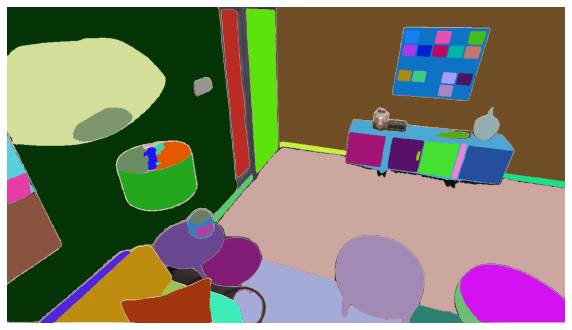

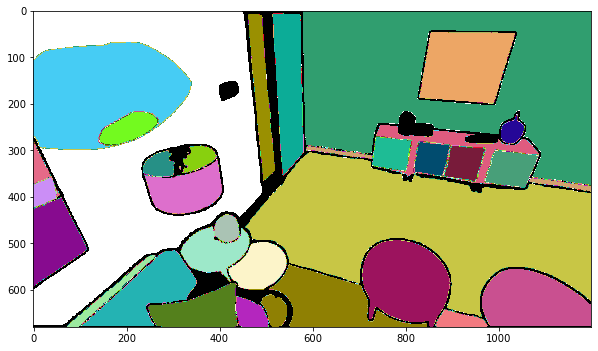

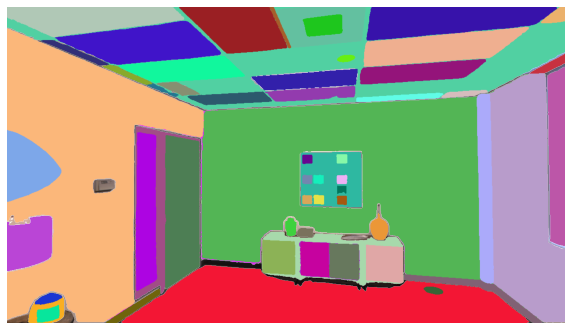

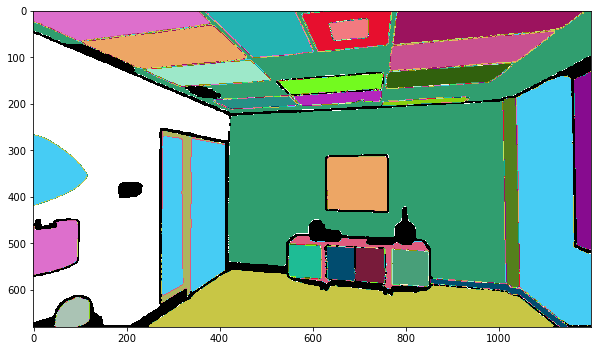

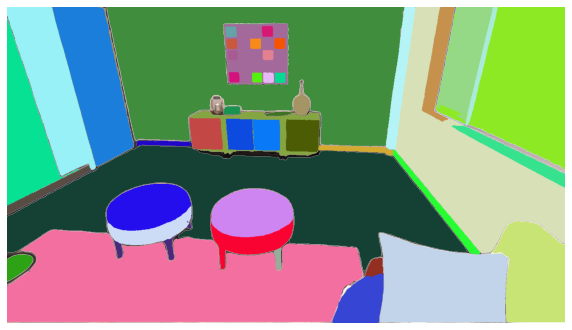

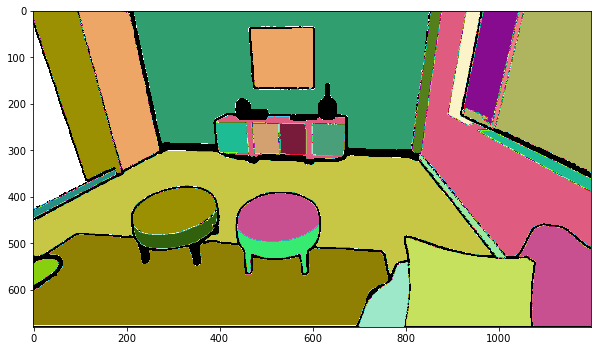

KeyboardInterrupt: 

In [17]:
# main loop
samples=None
visu=vis.visualizerForIds()

for i in range(0,10):
    currFramenumber=i*100
    color_data = cv2.imread(color_paths[currFramenumber])
    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
    masks, samples, max_id=createFrontMappingAutosort(currFramenumber, T_wc, K, depth_paths, mask_generator, 0,current_frame=image, samples=samples)
    visu.visualizer(masks)
    #print(i)
torch.cuda.empty_cache()